In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation, performance_metrics
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.utilities import regressor_coefficients

In [2]:
# Import train data
ne_train = pd.read_csv("../../data/ne_train.csv")
s_train = pd.read_csv("../../data/s_train.csv")

# Import test data
ne_test = pd.read_csv("../../data/ne_test.csv")
s_test = pd.read_csv("../../data/s_test.csv")

In [4]:
ne_train_plot = pd.merge(ne_train.date, ne_train["covid_19_confirmed_cases"], 
                                left_index=True, right_index=True)
ne_test_plot = pd.merge(ne_test.date, ne_test["covid_19_confirmed_cases"], 
                                left_index=True, right_index=True)

s_train_plot = pd.merge(s_train.date, s_train["covid_19_confirmed_cases"], 
                                left_index=True, right_index=True)
s_test_plot = pd.merge(s_test.date, s_test["covid_19_confirmed_cases"], 
                                left_index=True, right_index=True)

In [5]:
ne_train_plot.set_index("date", inplace = True)
ne_test_plot.set_index("date", inplace = True)

s_train_plot.set_index("date", inplace = True)
s_test_plot.set_index("date", inplace = True)

In [6]:
ne_train.rename(columns = {"date":"ds", "covid_19_confirmed_cases":"y"}, inplace = True)
ne_test.rename(columns = {"date":"ds", "covid_19_confirmed_cases":"y"}, inplace = True)

s_train.rename(columns = {"date":"ds", "covid_19_confirmed_cases":"y"}, inplace = True)
s_test.rename(columns = {"date":"ds", "covid_19_confirmed_cases":"y"}, inplace = True)

# Prophet Multiple Regressors
- From Multivariate EDA
    - NE: cat__social_distancing_encounters_grade_A, cat__social_distancing_encounters_grade_F, cat__social_distancing_travel_distance_grade_F, cat__social_distancing_total_grade_F, num__daily_state_test, num__precipitation, num__temperature have some weak correlation with covid_19_confirmed_cases
    - S: num__daily_state_test, num__temperature
- prior_scale default at 10
    - Decreasing the prior scale will add additional regularization
        - Dampens the effect of the regressor

In [18]:
help(Prophet.add_regressor)

Help on function add_regressor in module prophet.forecaster:

add_regressor(self, name, prior_scale=None, standardize='auto', mode=None)
    Add an additional regressor to be used for fitting and predicting.
    
    The dataframe passed to `fit` and `predict` will have a column with the
    specified name to be used as a regressor. When standardize='auto', the
    regressor will be standardized unless it is binary. The regression
    coefficient is given a prior with the specified scale parameter.
    Decreasing the prior scale will add additional regularization. If no
    prior scale is provided, self.holidays_prior_scale will be used.
    Mode can be specified as either 'additive' or 'multiplicative'. If not
    specified, self.seasonality_mode will be used. 'additive' means the
    effect of the regressor will be added to the trend, 'multiplicative'
    means it will multiply the trend.
    
    Parameters
    ----------
    name: string name of the regressor.
    prior_scale: opti

## Normal Prophet
- NE: MAE = 1640 confirmed cases
    - Way better than the Prophet Single Regressor baseline model
        - Way less bias in prediction
    - Underfit
    - Last trend not captured by changepoints
    - Except precipitation, all other regressors have high absolute coefficient values
- S: MAE = 8945 confirmed cases
    - Way better than the Prophet Single Regressor baseline model
        - Way less bias in prediction
    - Good fit
    - Last trend not captured by changepoints
    - num__daily_state_test has higher coefficient than num__temperature --> will keep it in

### NE Region

In [7]:
ne_cols = ["cat__social_distancing_encounters_grade_A",
           "cat__social_distancing_encounters_grade_F",
           "cat__social_distancing_travel_distance_grade_F",
           "cat__social_distancing_total_grade_F",
           "num__daily_state_test",
           "num__precipitation",
           "num__temperature"]

In [8]:
ne_normal_prophet = Prophet()

In [9]:
ne_normal_prophet.add_regressor("cat__social_distancing_encounters_grade_A")
ne_normal_prophet.add_regressor("cat__social_distancing_encounters_grade_F")
ne_normal_prophet.add_regressor("cat__social_distancing_travel_distance_grade_F")
ne_normal_prophet.add_regressor("cat__social_distancing_total_grade_F")
ne_normal_prophet.add_regressor("num__daily_state_test")
ne_normal_prophet.add_regressor("num__precipitation")
ne_normal_prophet.add_regressor("num__temperature")

In [10]:
ne_normal_prophet.fit(ne_train)

09:30:18 - cmdstanpy - INFO - Chain [1] start processing
09:30:18 - cmdstanpy - INFO - Chain [1] done processing


In [298]:
ne_normal_future = ne_normal_prophet.make_future_dataframe(periods=ne_train.shape[0])
ne_normal_future = pd.merge(ne_normal_future, ne_train.loc[:, ne_cols], left_index = True, right_index = True)
ne_normal_forecast = ne_normal_prophet.predict(ne_normal_future)

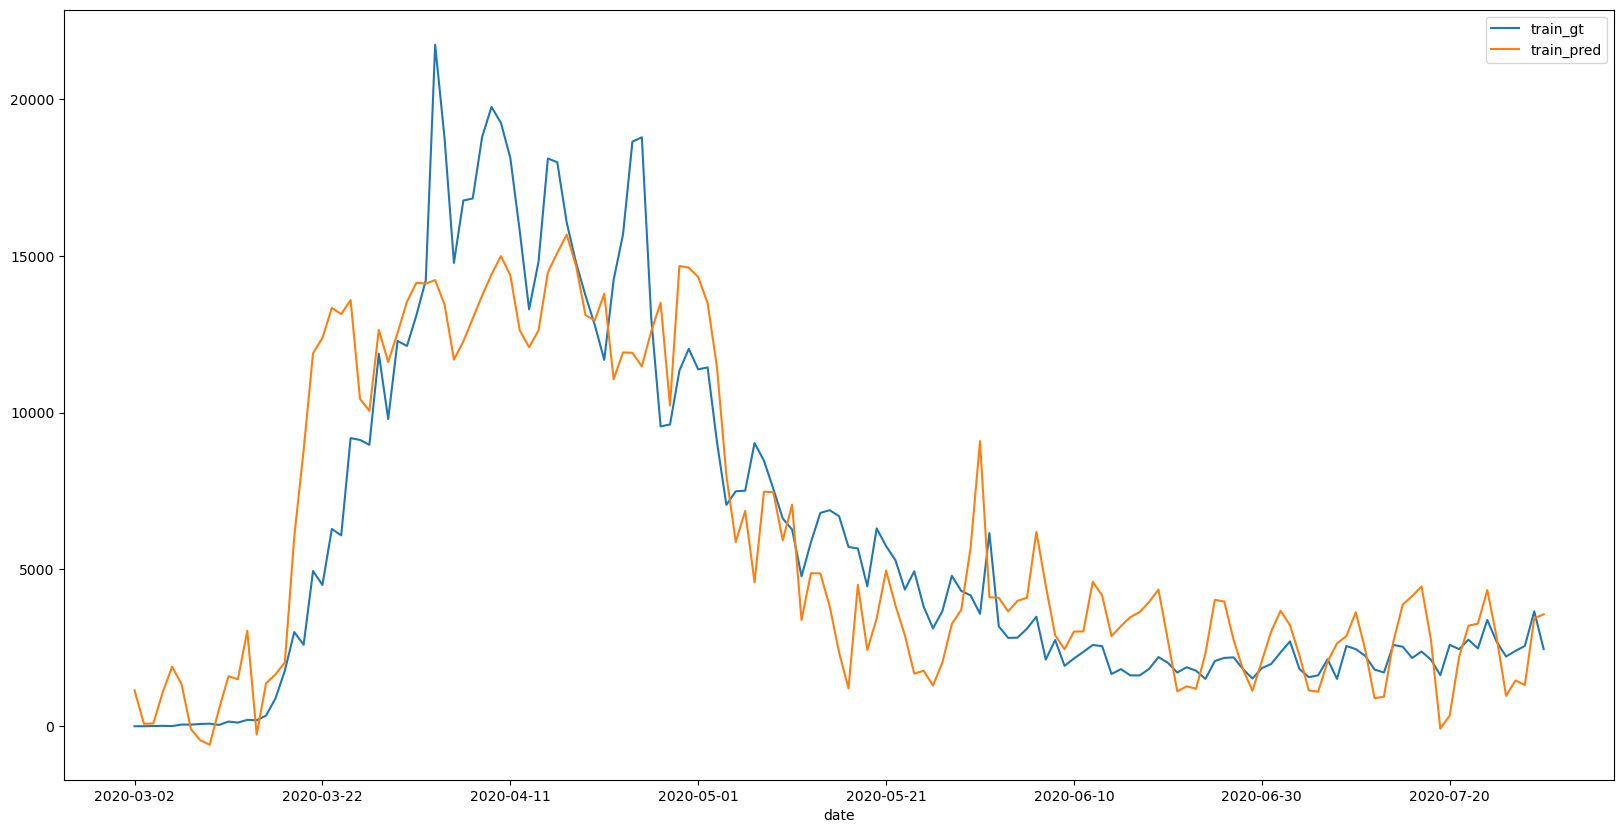

In [299]:
# Visualizing train data fitted values
ne_train_pred = ne_normal_forecast["yhat"]
ne_train_pred.index = ne_train_plot.index
pd.concat([ne_train_plot, ne_train_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['train_gt', 'train_pred'])

In [11]:
ne_normal_future = ne_normal_prophet.make_future_dataframe(periods=ne_test.shape[0])
ne_normal_future = pd.merge(ne_normal_future, ne_test.loc[:, ne_cols], left_index = True, right_index = True)
ne_normal_forecast = ne_normal_prophet.predict(ne_normal_future)

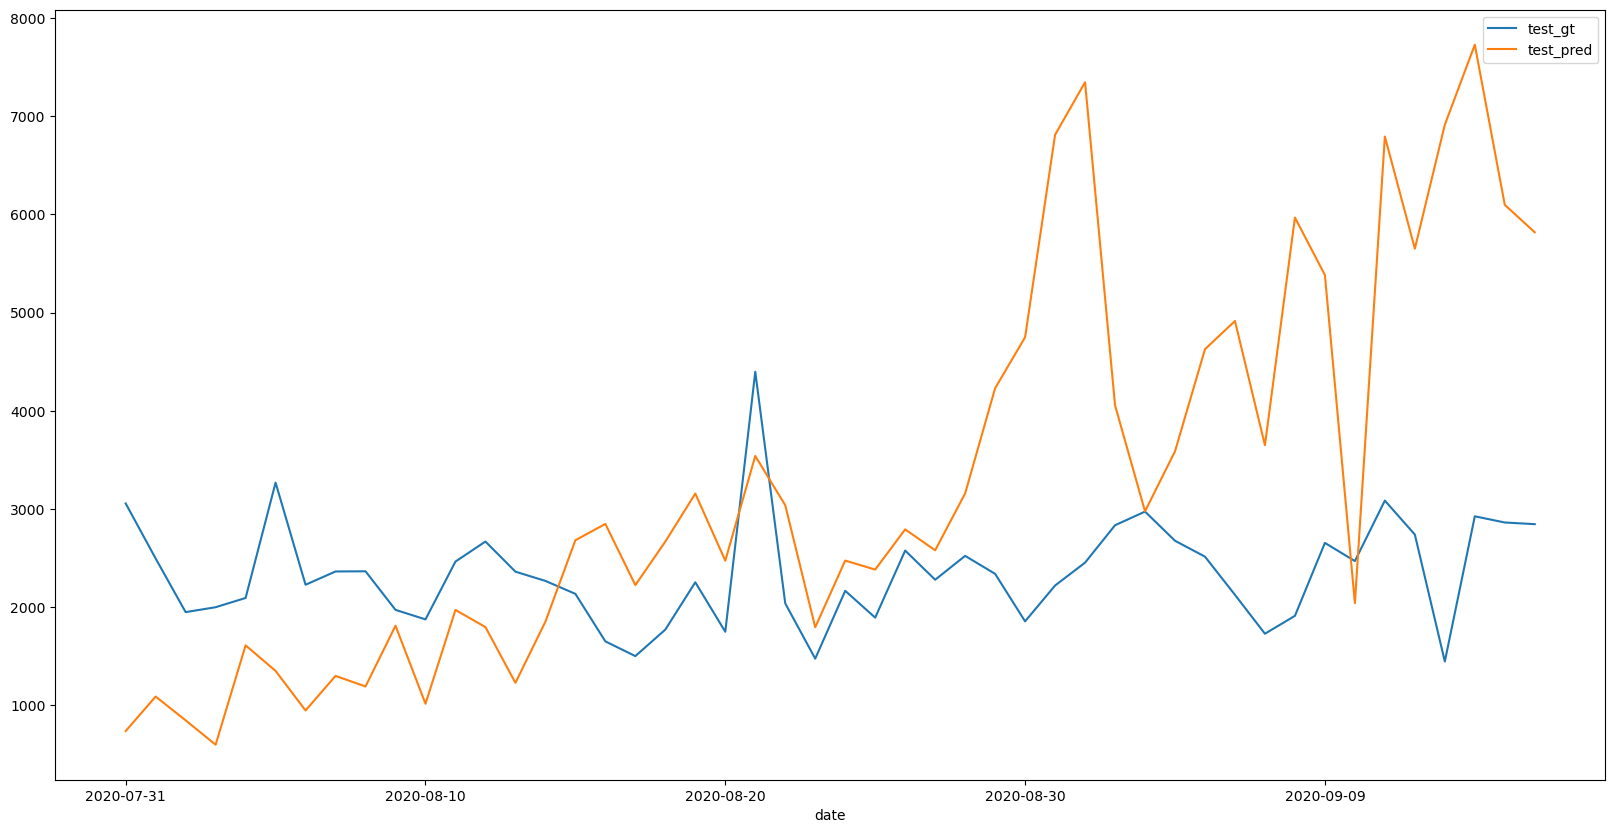

In [12]:
# Visualizing test data fitted values
ne_test_pred = ne_normal_forecast["yhat"]
ne_test_pred.index = ne_test_plot.index
pd.concat([ne_test_plot, ne_test_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['test_gt', 'test_pred'])

In [13]:
# MAE
mean_absolute_error(ne_test_plot, ne_test_pred)

1640.317945091949

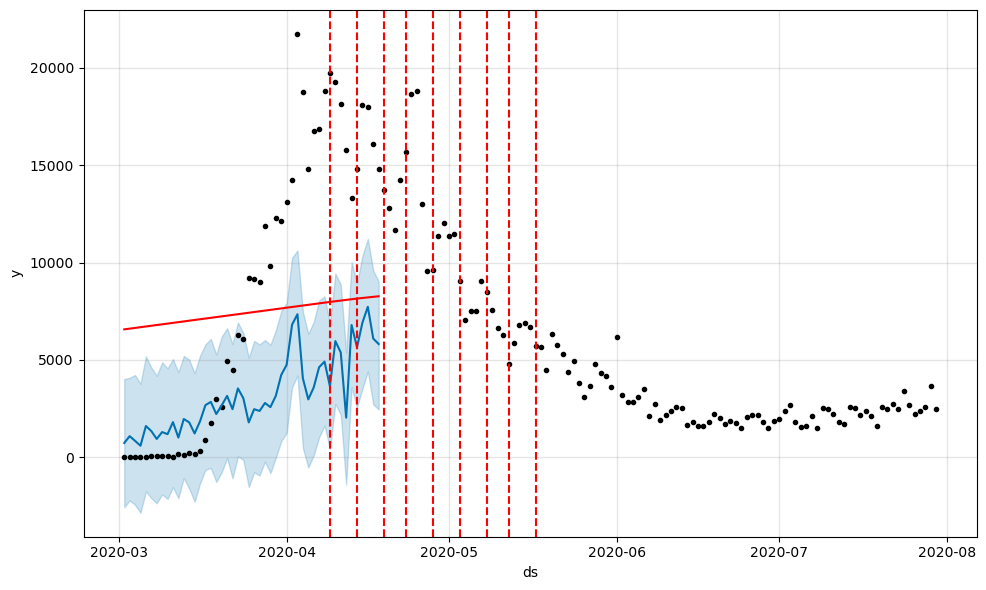

In [14]:
# Visualizing change points
fig = ne_normal_prophet.plot(ne_normal_forecast)
a = add_changepoints_to_plot(fig.gca(), ne_normal_prophet, ne_normal_forecast)

In [16]:
# Regressor Coefficients
regressor_coefficients(ne_normal_prophet)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,cat__social_distancing_encounters_grade_A,additive,0.000000,5219.918872,5219.918872,5219.918872
1,cat__social_distancing_encounters_grade_F,additive,0.000000,1349.008603,1349.008603,1349.008603
2,cat__social_distancing_travel_distance_grade_F,additive,0.000000,-2789.387084,-2789.387084,-2789.387084
3,cat__social_distancing_total_grade_F,additive,0.000000,-4167.324483,-4167.324483,-4167.324483
4,num__daily_state_test,additive,0.314669,1678.501970,1678.501970,1678.501970
5,num__precipitation,additive,0.019583,-48.676967,-48.676967,-48.676967
6,num__temperature,additive,0.318764,-2030.509171,-2030.509171,-2030.509171


### S Region

In [165]:
s_cols = ["num__daily_state_test", "num__temperature"]

In [166]:
s_normal_prophet = Prophet()

In [167]:
s_normal_prophet.add_regressor("num__daily_state_test")
s_normal_prophet.add_regressor("num__temperature")

In [161]:
s_normal_prophet.fit(s_train)

21:57:11 - cmdstanpy - INFO - Chain [1] start processing
21:57:11 - cmdstanpy - INFO - Chain [1] done processing


In [155]:
s_normal_future = s_normal_prophet.make_future_dataframe(periods=s_train.shape[0])
s_normal_future = pd.merge(s_normal_future, s_train.loc[:, ne_cols], left_index = True, right_index = True)
s_normal_forecast = s_normal_prophet.predict(s_normal_future)

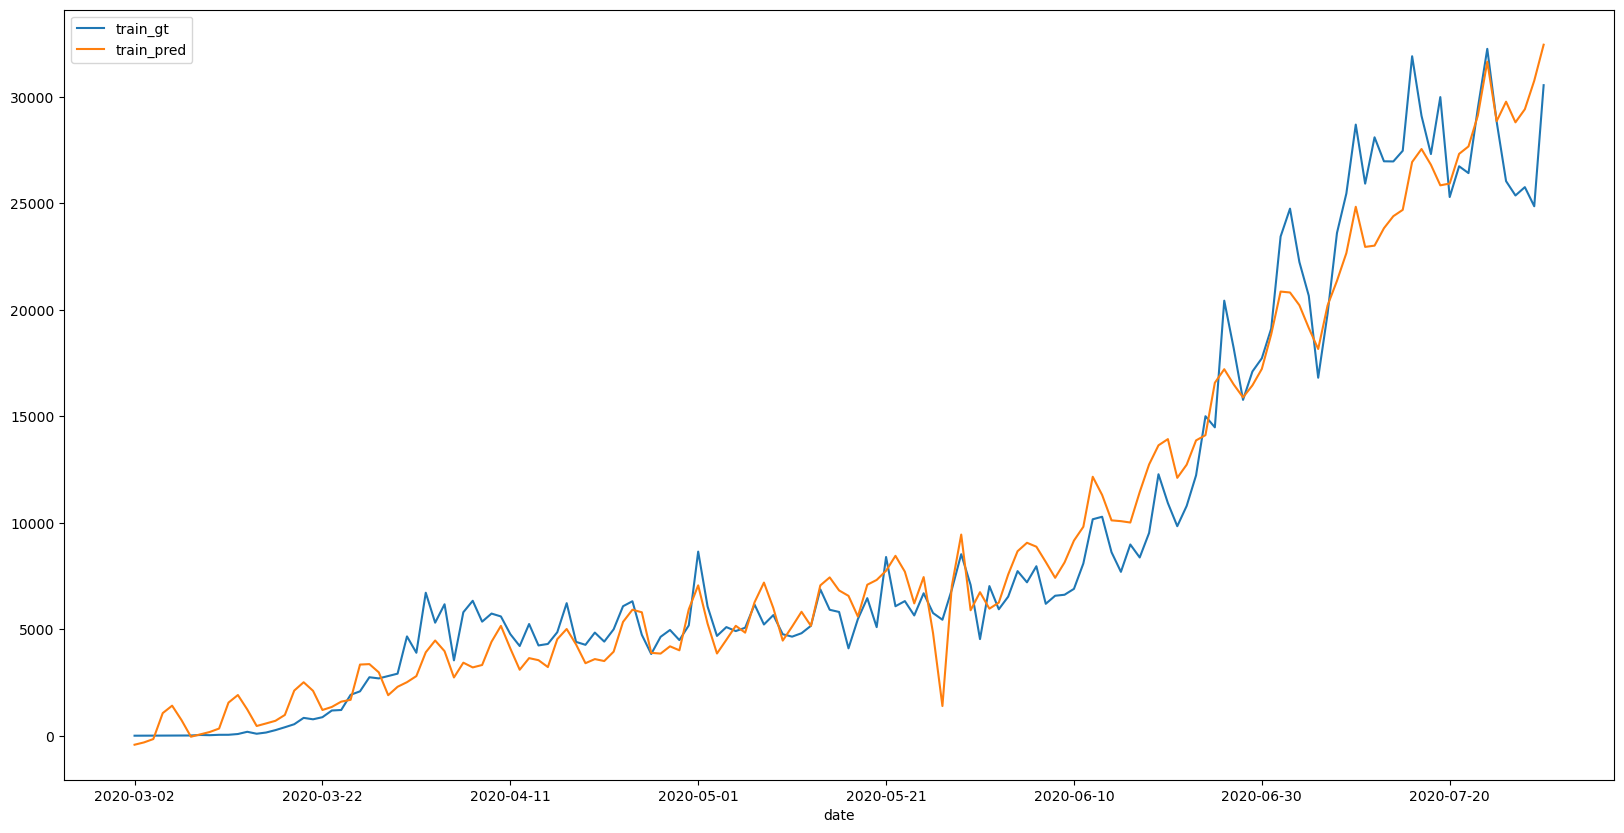

In [156]:
# Visualizing train data fitted values
s_train_pred = s_normal_forecast["yhat"]
s_train_pred.index = s_train_plot.index
pd.concat([s_train_plot, s_train_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['train_gt', 'train_pred'])

In [162]:
s_normal_future = s_normal_prophet.make_future_dataframe(periods=s_test.shape[0])
s_normal_future = pd.merge(s_normal_future, s_test.loc[:, s_cols], left_index = True, right_index = True)
s_normal_forecast = s_normal_prophet.predict(s_normal_future)

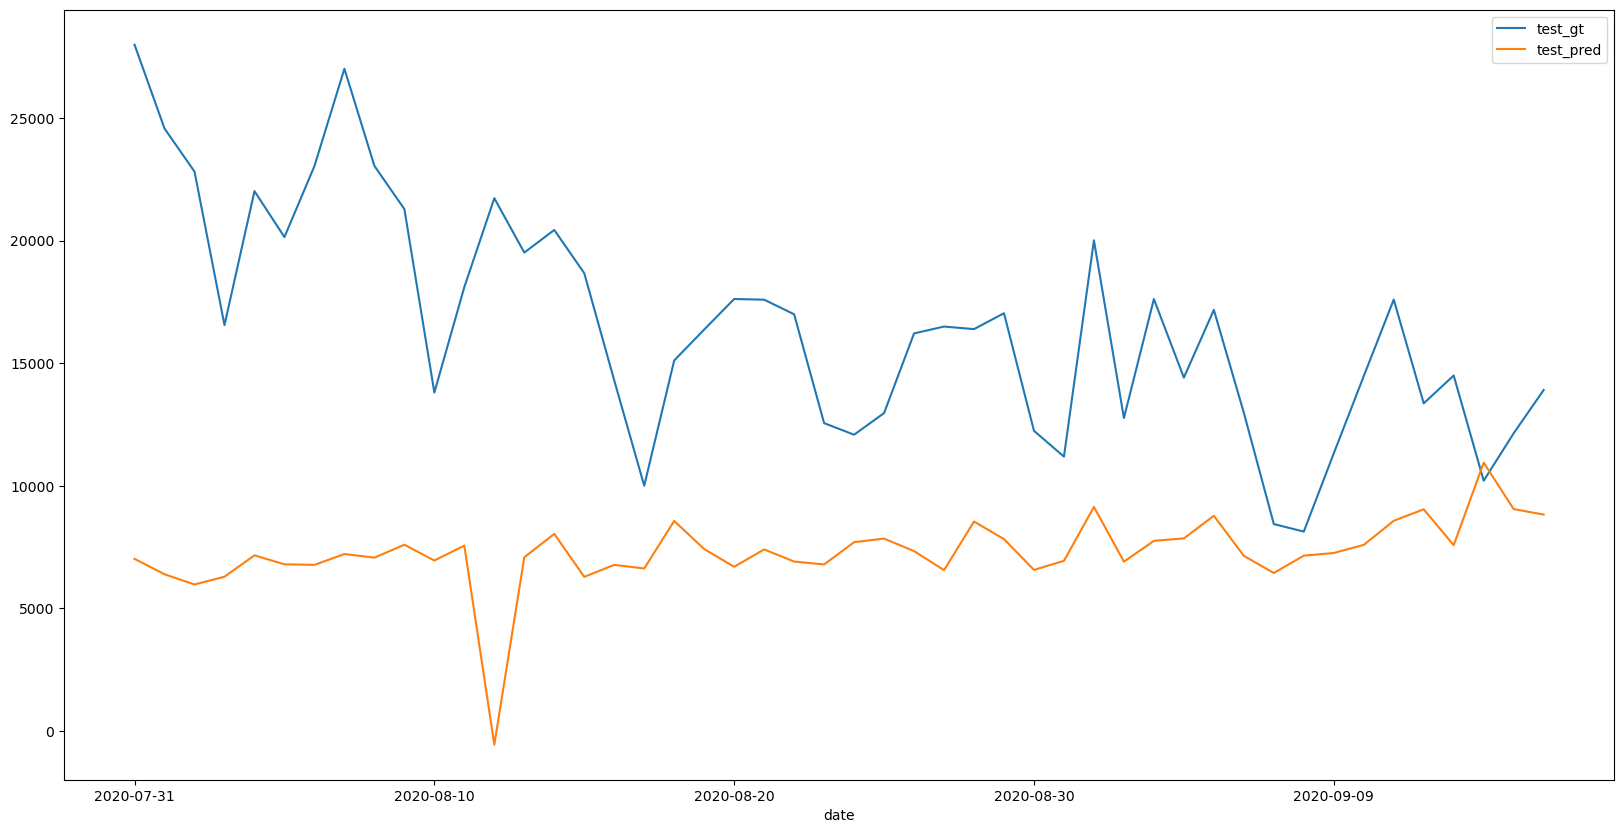

In [163]:
# Visualizing test data fitted values
s_test_pred = s_normal_forecast["yhat"]
s_test_pred.index = s_test_plot.index
pd.concat([s_test_plot, s_test_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['test_gt', 'test_pred'])

In [164]:
# MAE
mean_absolute_error(s_test_plot, s_test_pred)

9292.90447662061

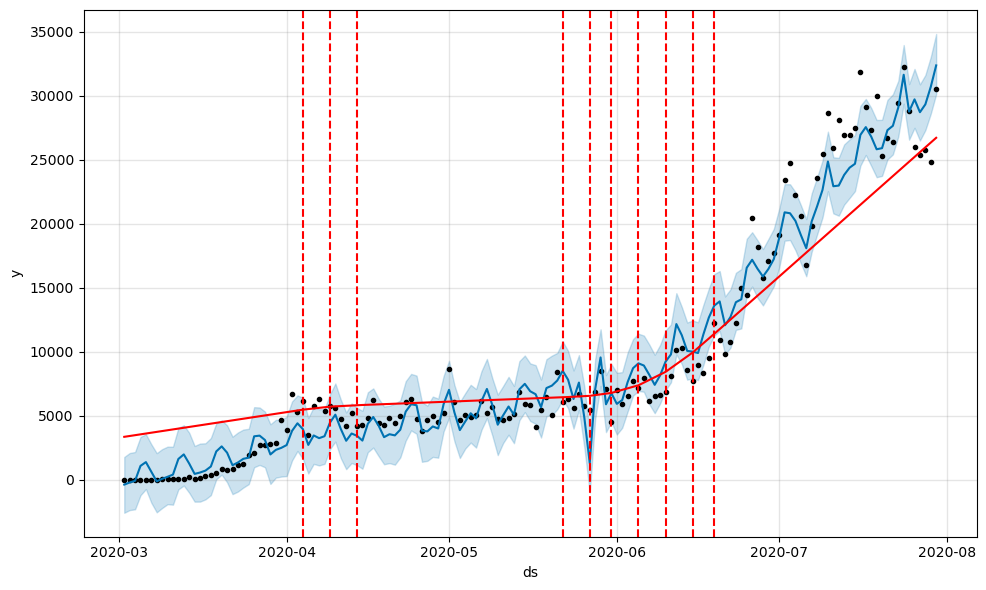

In [142]:
# Visualizing change points
fig = s_normal_prophet.plot(s_normal_forecast)
a = add_changepoints_to_plot(fig.gca(), s_normal_prophet, s_normal_forecast)

In [150]:
# Regressor Coefficients
regressor_coefficients(s_normal_prophet)[["regressor", "coef"]].sort_values("coef")

,regressor,coef
1,num__temperature,140.511326
0,num__daily_state_test,2467.125459


# Tuned Prophet
- NE: MAE = 8441 confirmed cases
    - Better fit but severely overfitting
    - Adding more predictors increases the seasonality effect
    - All coefficients seem equally important
- S: MAE = 11042 confirmed cases
    - Better fit but severely overfitting
    - Adding more predictors increases the seasonality effect
    - All coefficients seem equally important

## NE Region

In [323]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5, 0.6, 0.7],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

In [324]:
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
ne_maes = []

In [325]:
# Use cross validation to evaluate all parameters
for params in all_params:
    ne_tuned_prophet = Prophet(**params)
    ne_tuned_prophet.add_country_holidays(country_name='US')
    ne_tuned_prophet.add_regressor("cat__social_distancing_encounters_grade_A")
    ne_tuned_prophet.add_regressor("cat__social_distancing_encounters_grade_F")
    ne_tuned_prophet.add_regressor("cat__social_distancing_travel_distance_grade_F")
    ne_tuned_prophet.add_regressor("cat__social_distancing_total_grade_F")
    ne_tuned_prophet.add_regressor("num__daily_state_test")
    ne_tuned_prophet.add_regressor("num__temperature")
    
    ne_tuned_prophet.fit(ne_train) 
    
    df_cv = cross_validation(ne_tuned_prophet, initial='90 days', 
                             period='15 days', horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv)
    ne_maes.append(df_p["mae"].values[0])

23:20:00 - cmdstanpy - INFO - Chain [1] start processing
23:20:00 - cmdstanpy - INFO - Chain [1] done processing
23:20:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:20:00 - cmdstanpy - INFO - Chain [1] start processing
23:20:01 - cmdstanpy - INFO - Chain [1] done processing
23:20:01 - cmdstanpy - INFO - Chain [1] start processing
23:20:01 - cmdstanpy - INFO - Chain [1] start processing
23:20:01 - cmdstanpy - INFO - Chain [1] done processing
23:20:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:20:01 - cmdstanpy - INFO - Chain [1] start processing
23:20:01 - cmdstanpy - INFO - Chain [1] start processing
23:20:01 - cmdstanpy - INFO - Chain [1] done processing
23:20:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated ab

23:20:11 - cmdstanpy - INFO - Chain [1] start processing
23:20:11 - cmdstanpy - INFO - Chain [1] done processing
23:20:12 - cmdstanpy - INFO - Chain [1] start processing
23:20:12 - cmdstanpy - INFO - Chain [1] start processing
23:20:12 - cmdstanpy - INFO - Chain [1] start processing
23:20:12 - cmdstanpy - INFO - Chain [1] done processing
23:20:12 - cmdstanpy - INFO - Chain [1] done processing
23:20:12 - cmdstanpy - INFO - Chain [1] done processing
23:20:12 - cmdstanpy - INFO - Chain [1] start processing
23:20:12 - cmdstanpy - INFO - Chain [1] done processing
23:20:13 - cmdstanpy - INFO - Chain [1] start processing
23:20:13 - cmdstanpy - INFO - Chain [1] start processing
23:20:13 - cmdstanpy - INFO - Chain [1] start processing
23:20:13 - cmdstanpy - INFO - Chain [1] done processing
23:20:13 - cmdstanpy - INFO - Chain [1] done processing
23:20:13 - cmdstanpy - INFO - Chain [1] done processing
23:20:13 - cmdstanpy - INFO - Chain [1] start processing
23:20:13 - cmdstanpy - INFO - Chain [1]

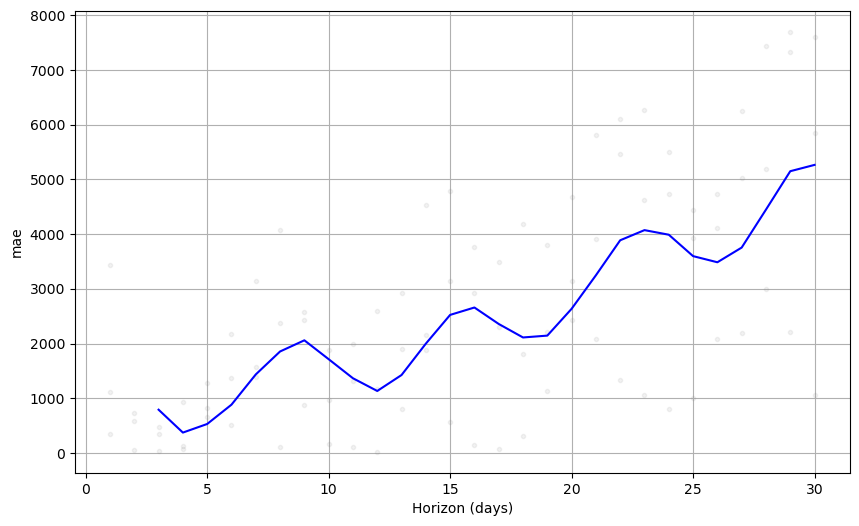

In [326]:
fig = plot_cross_validation_metric(df_cv, metric='mae')

In [327]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results["mae"] = ne_maes
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale          mae
0                     0.001                     0.01  2741.683831
1                     0.001                     0.10  2990.342783
2                     0.001                     1.00  2995.569480
3                     0.001                    10.00  2992.169686
4                     0.010                     0.01  2867.603365
5                     0.010                     0.10  3059.776069
6                     0.010                     1.00  3052.893474
7                     0.010                    10.00  3031.360344
8                     0.100                     0.01  1504.544940
9                     0.100                     0.10  1275.758294
10                    0.100                     1.00  1300.281831
11                    0.100                    10.00  1278.069438
12                    0.500                     0.01   871.945074
13                    0.500                     0.10   806.091776
14        

In [328]:
# Find the best hyperparameter
best_params = all_params[np.argmin(ne_maes)]
print(best_params)

{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 1.0}


## NE Region Model

In [333]:
ne_tuned_prophet = Prophet(changepoint_prior_scale = 0.7,
                           seasonality_prior_scale = 1.0)
ne_tuned_prophet.add_country_holidays(country_name='US')
ne_tuned_prophet.add_regressor("cat__social_distancing_encounters_grade_A")
ne_tuned_prophet.add_regressor("cat__social_distancing_encounters_grade_F")
ne_tuned_prophet.add_regressor("cat__social_distancing_travel_distance_grade_F")
ne_tuned_prophet.add_regressor("cat__social_distancing_total_grade_F")
ne_tuned_prophet.add_regressor("num__daily_state_test")
ne_tuned_prophet.add_regressor("num__temperature")

In [334]:
ne_tuned_prophet.fit(ne_train) 

23:20:33 - cmdstanpy - INFO - Chain [1] start processing
23:20:33 - cmdstanpy - INFO - Chain [1] done processing


In [331]:
ne_tuned_future = ne_tuned_prophet.make_future_dataframe(periods=ne_train.shape[0])
ne_tuned_future = pd.merge(ne_tuned_future, ne_train.loc[:, ne_cols], left_index = True, right_index = True)
ne_tuned_forecast = ne_tuned_prophet.predict(ne_tuned_future)

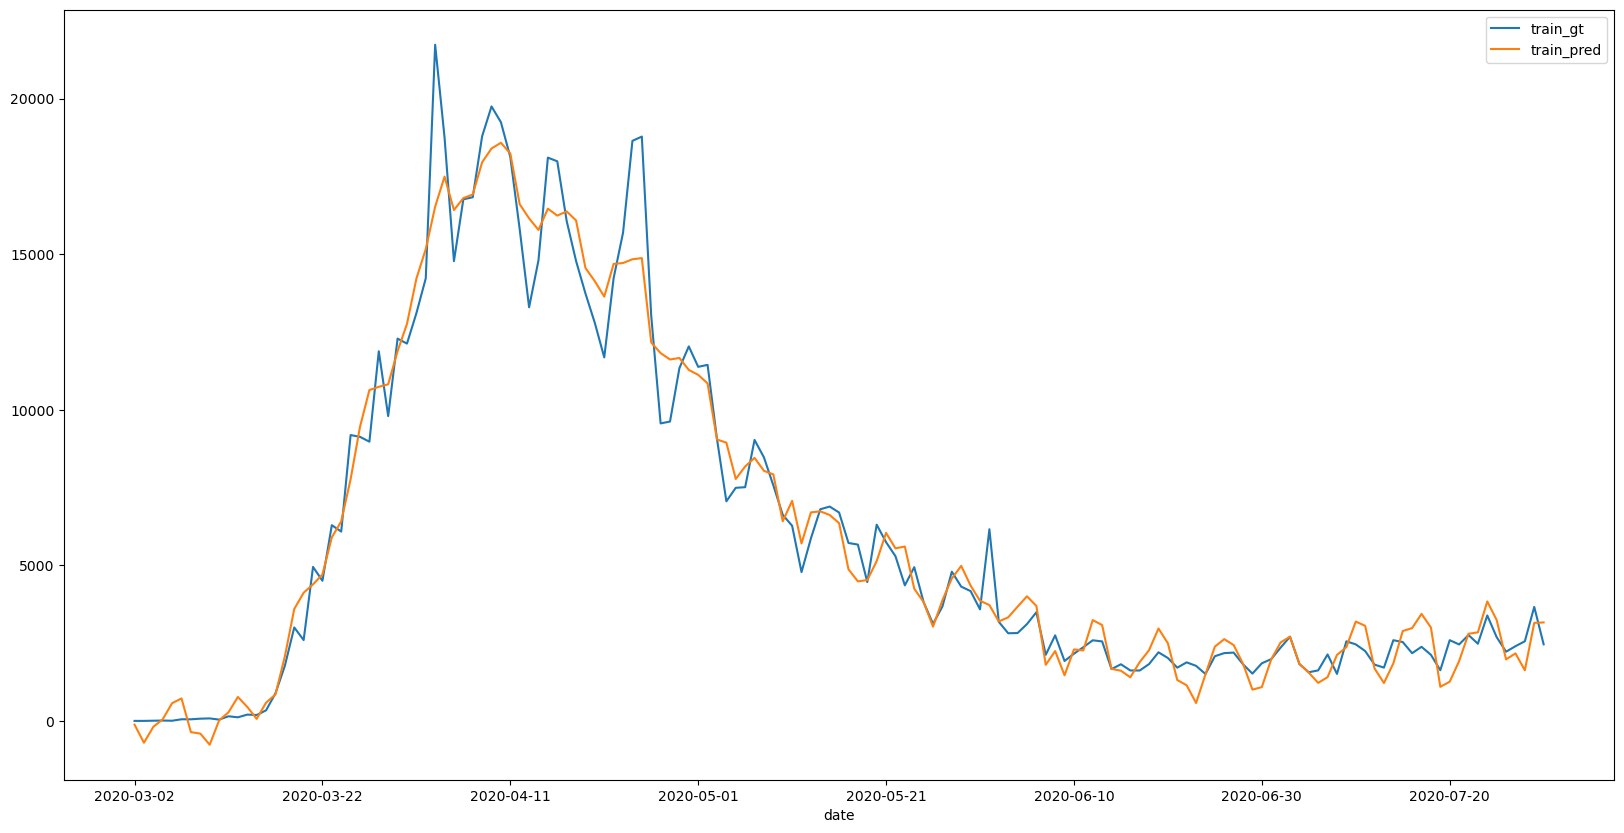

In [332]:
# Visualizing train data fitted values
ne_train_pred = ne_tuned_forecast["yhat"]
ne_train_pred.index = ne_train_plot.index
pd.concat([ne_train_plot, ne_train_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['train_gt', 'train_pred'])

In [335]:
ne_tuned_future = ne_tuned_prophet.make_future_dataframe(periods=ne_test.shape[0])
ne_tuned_future = pd.merge(ne_tuned_future, ne_test.loc[:, ne_cols], left_index = True, right_index = True)
ne_tuned_forecast = ne_tuned_prophet.predict(ne_tuned_future)

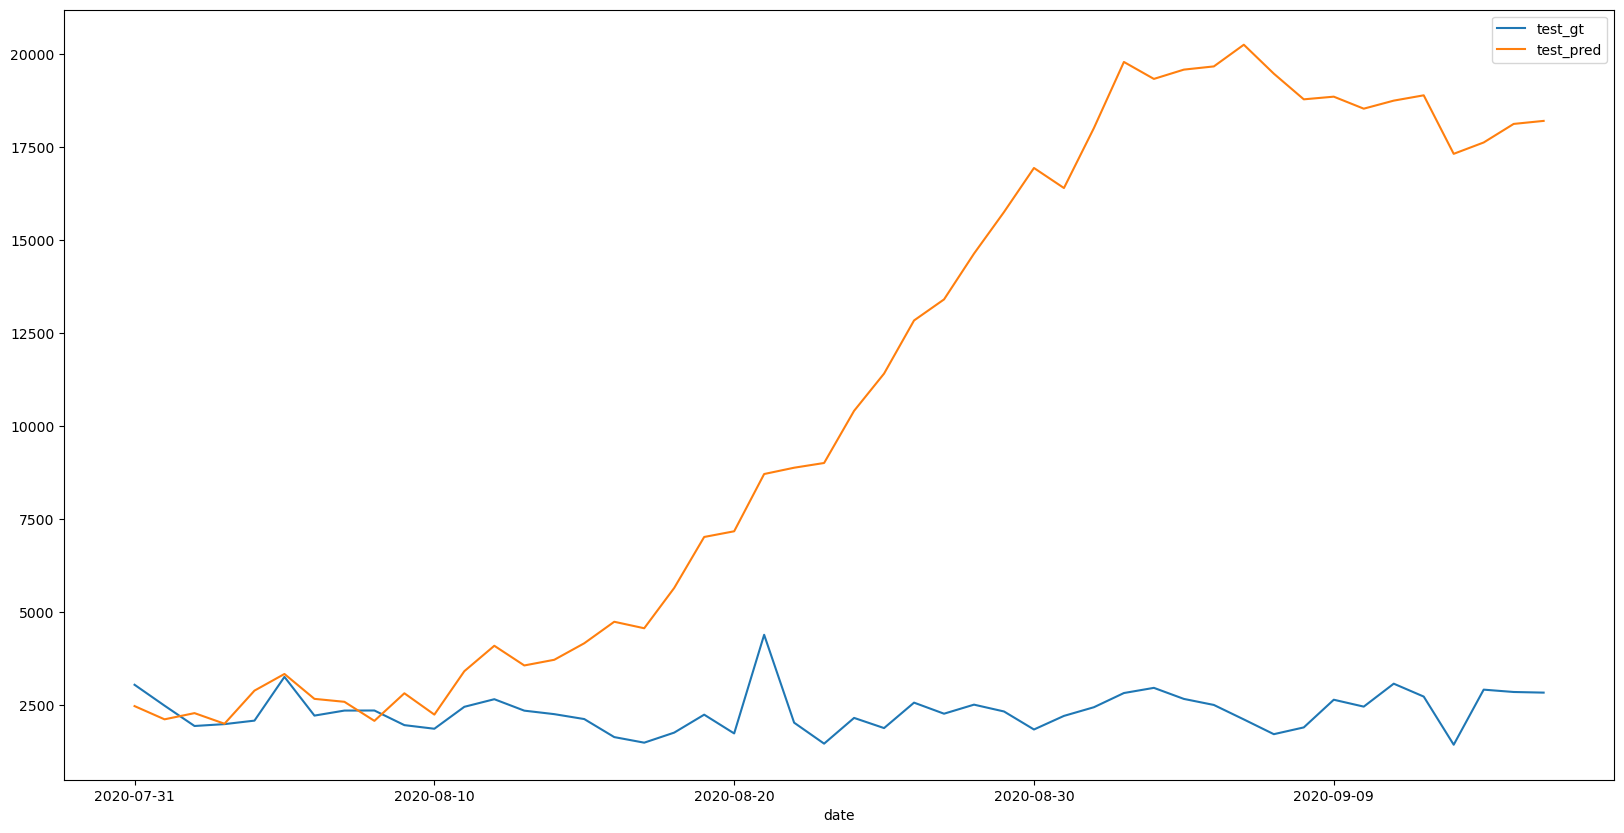

In [336]:
# Visualizing test data fitted values
ne_test_pred = ne_tuned_forecast["yhat"]
ne_test_pred.index = ne_test_plot.index
pd.concat([ne_test_plot, ne_test_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['test_gt', 'test_pred'])

In [337]:
# MAE
mean_absolute_error(ne_test_plot, ne_test_pred)

8441.326109984633

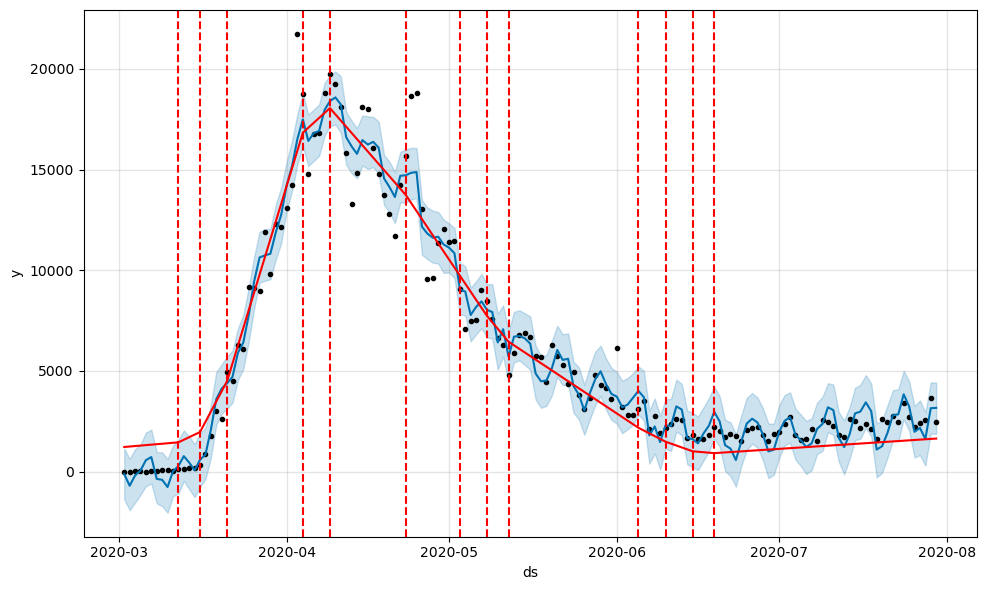

In [255]:
# Visualizing change points
fig = ne_tuned_prophet.plot(ne_tuned_forecast)
a = add_changepoints_to_plot(fig.gca(), ne_tuned_prophet, ne_tuned_forecast)

In [256]:
# Regressor Coefficients
regressor_coefficients(ne_tuned_prophet)[["regressor", "coef"]].sort_values("coef")

,regressor,coef
3,cat__social_distancing_total_grade_F,-1031.193904
5,num__temperature,-492.726879
2,cat__social_distancing_travel_distance_grade_F,337.976403
0,cat__social_distancing_encounters_grade_A,485.710817
1,cat__social_distancing_encounters_grade_F,852.077038
4,num__daily_state_test,1328.385099


## S Region

In [260]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5, 0.6, 0.7, 0.8, 0.9],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'changepoint_range': [0.8, 0.9, 1.0]
}

In [261]:
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
s_maes = []

In [262]:
# Use cross validation to evaluate all parameters
for params in all_params:
    s_tuned_prophet = Prophet(**params)
    s_tuned_prophet.add_country_holidays(country_name='US')
    s_tuned_prophet.add_regressor("num__daily_state_test")
    s_tuned_prophet.add_regressor("num__temperature")
    s_tuned_prophet.fit(s_train) 
    
    df_cv = cross_validation(s_tuned_prophet, initial='90 days', 
                             period='15 days', horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv)
    s_maes.append(df_p["mae"].values[0])

22:36:38 - cmdstanpy - INFO - Chain [1] start processing
22:36:38 - cmdstanpy - INFO - Chain [1] done processing
22:36:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:36:38 - cmdstanpy - INFO - Chain [1] start processing
22:36:38 - cmdstanpy - INFO - Chain [1] done processing
22:36:38 - cmdstanpy - INFO - Chain [1] start processing
22:36:38 - cmdstanpy - INFO - Chain [1] start processing
22:36:38 - cmdstanpy - INFO - Chain [1] done processing
22:36:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:36:38 - cmdstanpy - INFO - Chain [1] start processing
22:36:38 - cmdstanpy - INFO - Chain [1] start processing
22:36:38 - cmdstanpy - INFO - Chain [1] done processing
22:36:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated ab

22:36:45 - cmdstanpy - INFO - Chain [1] start processing
22:36:45 - cmdstanpy - INFO - Chain [1] done processing
22:36:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:36:45 - cmdstanpy - INFO - Chain [1] start processing
22:36:45 - cmdstanpy - INFO - Chain [1] done processing
22:36:46 - cmdstanpy - INFO - Chain [1] start processing
22:36:46 - cmdstanpy - INFO - Chain [1] start processing
22:36:46 - cmdstanpy - INFO - Chain [1] done processing
22:36:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:36:46 - cmdstanpy - INFO - Chain [1] start processing
22:36:46 - cmdstanpy - INFO - Chain [1] start processing
22:36:46 - cmdstanpy - INFO - Chain [1] done processing
22:36:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated ab

22:36:54 - cmdstanpy - INFO - Chain [1] start processing
22:36:54 - cmdstanpy - INFO - Chain [1] start processing
22:36:54 - cmdstanpy - INFO - Chain [1] start processing
22:36:54 - cmdstanpy - INFO - Chain [1] done processing
22:36:54 - cmdstanpy - INFO - Chain [1] done processing
22:36:54 - cmdstanpy - INFO - Chain [1] done processing
22:36:54 - cmdstanpy - INFO - Chain [1] start processing
22:36:54 - cmdstanpy - INFO - Chain [1] done processing
22:36:55 - cmdstanpy - INFO - Chain [1] start processing
22:36:55 - cmdstanpy - INFO - Chain [1] start processing
22:36:55 - cmdstanpy - INFO - Chain [1] done processing
22:36:55 - cmdstanpy - INFO - Chain [1] start processing
22:36:55 - cmdstanpy - INFO - Chain [1] done processing
22:36:55 - cmdstanpy - INFO - Chain [1] done processing
22:36:55 - cmdstanpy - INFO - Chain [1] start processing
22:36:55 - cmdstanpy - INFO - Chain [1] done processing
22:36:55 - cmdstanpy - INFO - Chain [1] start processing
22:36:55 - cmdstanpy - INFO - Chain [1]

22:37:10 - cmdstanpy - INFO - Chain [1] done processing
22:37:10 - cmdstanpy - INFO - Chain [1] start processing
22:37:10 - cmdstanpy - INFO - Chain [1] done processing
22:37:10 - cmdstanpy - INFO - Chain [1] start processing
22:37:10 - cmdstanpy - INFO - Chain [1] start processing
22:37:10 - cmdstanpy - INFO - Chain [1] done processing
22:37:10 - cmdstanpy - INFO - Chain [1] start processing
22:37:10 - cmdstanpy - INFO - Chain [1] done processing
22:37:11 - cmdstanpy - INFO - Chain [1] done processing
22:37:11 - cmdstanpy - INFO - Chain [1] start processing
22:37:11 - cmdstanpy - INFO - Chain [1] done processing
22:37:11 - cmdstanpy - INFO - Chain [1] start processing
22:37:11 - cmdstanpy - INFO - Chain [1] start processing
22:37:11 - cmdstanpy - INFO - Chain [1] start processing
22:37:11 - cmdstanpy - INFO - Chain [1] done processing
22:37:11 - cmdstanpy - INFO - Chain [1] done processing
22:37:12 - cmdstanpy - INFO - Chain [1] done processing
22:37:12 - cmdstanpy - INFO - Chain [1] 

22:37:29 - cmdstanpy - INFO - Chain [1] done processing
22:37:29 - cmdstanpy - INFO - Chain [1] start processing
22:37:29 - cmdstanpy - INFO - Chain [1] start processing
22:37:29 - cmdstanpy - INFO - Chain [1] start processing
22:37:29 - cmdstanpy - INFO - Chain [1] done processing
22:37:29 - cmdstanpy - INFO - Chain [1] done processing
22:37:30 - cmdstanpy - INFO - Chain [1] done processing
22:37:30 - cmdstanpy - INFO - Chain [1] start processing
22:37:30 - cmdstanpy - INFO - Chain [1] done processing
22:37:30 - cmdstanpy - INFO - Chain [1] start processing
22:37:30 - cmdstanpy - INFO - Chain [1] start processing
22:37:30 - cmdstanpy - INFO - Chain [1] start processing
22:37:30 - cmdstanpy - INFO - Chain [1] done processing
22:37:30 - cmdstanpy - INFO - Chain [1] done processing
22:37:31 - cmdstanpy - INFO - Chain [1] done processing
22:37:31 - cmdstanpy - INFO - Chain [1] start processing
22:37:31 - cmdstanpy - INFO - Chain [1] done processing
22:37:31 - cmdstanpy - INFO - Chain [1] 

22:37:48 - cmdstanpy - INFO - Chain [1] done processing
22:37:48 - cmdstanpy - INFO - Chain [1] start processing
22:37:48 - cmdstanpy - INFO - Chain [1] done processing
22:37:49 - cmdstanpy - INFO - Chain [1] start processing
22:37:49 - cmdstanpy - INFO - Chain [1] start processing
22:37:49 - cmdstanpy - INFO - Chain [1] start processing
22:37:49 - cmdstanpy - INFO - Chain [1] done processing
22:37:49 - cmdstanpy - INFO - Chain [1] done processing
22:37:49 - cmdstanpy - INFO - Chain [1] done processing
22:37:49 - cmdstanpy - INFO - Chain [1] start processing
22:37:49 - cmdstanpy - INFO - Chain [1] done processing
22:37:50 - cmdstanpy - INFO - Chain [1] start processing
22:37:50 - cmdstanpy - INFO - Chain [1] start processing
22:37:50 - cmdstanpy - INFO - Chain [1] start processing
22:37:50 - cmdstanpy - INFO - Chain [1] done processing
22:37:50 - cmdstanpy - INFO - Chain [1] done processing
22:37:50 - cmdstanpy - INFO - Chain [1] done processing
22:37:50 - cmdstanpy - INFO - Chain [1] 

22:38:06 - cmdstanpy - INFO - Chain [1] done processing
22:38:07 - cmdstanpy - INFO - Chain [1] start processing
22:38:07 - cmdstanpy - INFO - Chain [1] start processing
22:38:07 - cmdstanpy - INFO - Chain [1] start processing
22:38:07 - cmdstanpy - INFO - Chain [1] done processing
22:38:07 - cmdstanpy - INFO - Chain [1] done processing
22:38:07 - cmdstanpy - INFO - Chain [1] done processing
22:38:07 - cmdstanpy - INFO - Chain [1] start processing
22:38:07 - cmdstanpy - INFO - Chain [1] done processing
22:38:08 - cmdstanpy - INFO - Chain [1] start processing
22:38:08 - cmdstanpy - INFO - Chain [1] start processing
22:38:08 - cmdstanpy - INFO - Chain [1] start processing
22:38:08 - cmdstanpy - INFO - Chain [1] done processing
22:38:08 - cmdstanpy - INFO - Chain [1] done processing
22:38:08 - cmdstanpy - INFO - Chain [1] done processing
22:38:08 - cmdstanpy - INFO - Chain [1] start processing
22:38:08 - cmdstanpy - INFO - Chain [1] done processing
22:38:09 - cmdstanpy - INFO - Chain [1] 

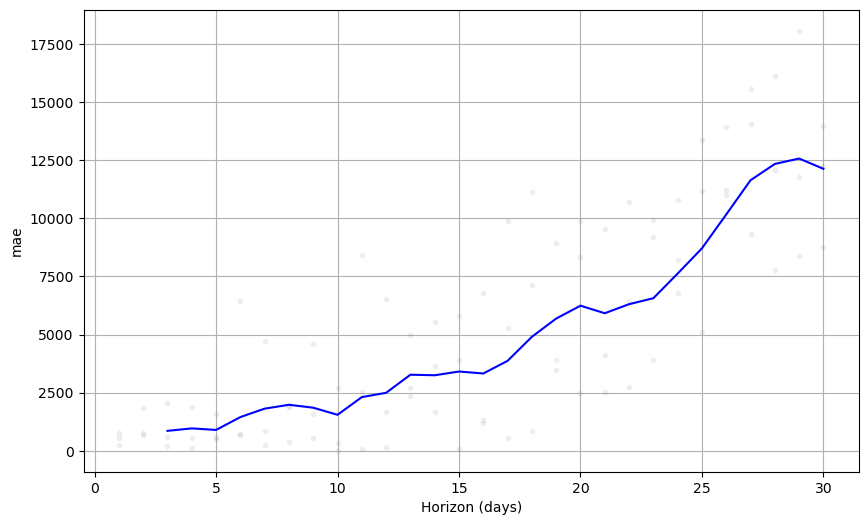

In [263]:
fig = plot_cross_validation_metric(df_cv, metric='mae')

In [264]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results["mae"] = s_maes
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale  changepoint_range  \
0                     0.001                     0.01                0.8   
1                     0.001                     0.01                0.9   
2                     0.001                     0.01                1.0   
3                     0.001                     0.10                0.8   
4                     0.001                     0.10                0.9   
..                      ...                      ...                ...   
91                    0.900                     1.00                0.9   
92                    0.900                     1.00                1.0   
93                    0.900                    10.00                0.8   
94                    0.900                    10.00                0.9   
95                    0.900                    10.00                1.0   

            mae  
0   3699.082325  
1   3698.861296  
2   3698.682191  
3   3594.405658  
4   3593.

In [265]:
# Find the best hyperparameter
best_params = all_params[np.argmin(s_maes)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'changepoint_range': 1.0}


## S Region Model

In [276]:
s_tuned_prophet = Prophet(changepoint_prior_scale = 0.5,
                           seasonality_prior_scale = 1.0,
                         changepoint_range=1.0)
s_tuned_prophet.add_country_holidays(country_name='US')
s_tuned_prophet.add_regressor("num__daily_state_test")
s_tuned_prophet.add_regressor("num__temperature")

In [277]:
s_tuned_prophet.fit(s_train) 

22:42:00 - cmdstanpy - INFO - Chain [1] start processing
22:42:00 - cmdstanpy - INFO - Chain [1] done processing


In [278]:
s_tuned_future = s_tuned_prophet.make_future_dataframe(periods=s_train.shape[0])
s_tuned_future = pd.merge(s_tuned_future, s_train.loc[:, s_cols], left_index = True, right_index = True)
s_tuned_forecast = s_tuned_prophet.predict(s_tuned_future)

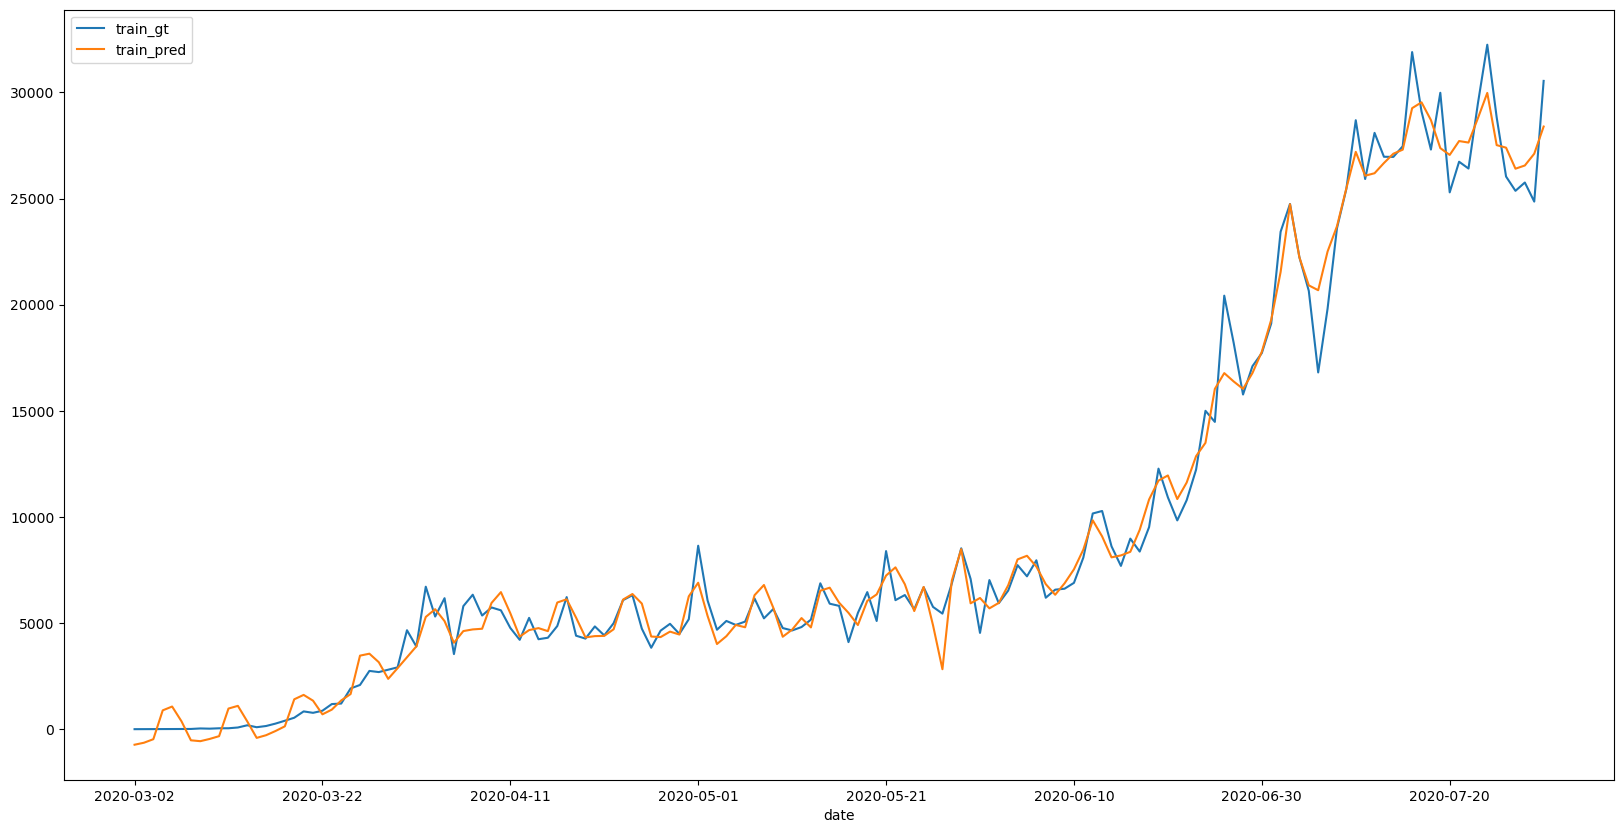

In [269]:
# Visualizing train data fitted values
s_train_pred = s_tuned_forecast["yhat"]
s_train_pred.index = s_train_plot.index
pd.concat([s_train_plot, s_train_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['train_gt', 'train_pred'])

In [272]:
s_tuned_future = s_tuned_prophet.make_future_dataframe(periods=s_test.shape[0])
s_tuned_future = pd.merge(s_tuned_future, s_test.loc[:, s_cols], left_index = True, right_index = True)
s_tuned_forecast = s_tuned_prophet.predict(s_tuned_future)

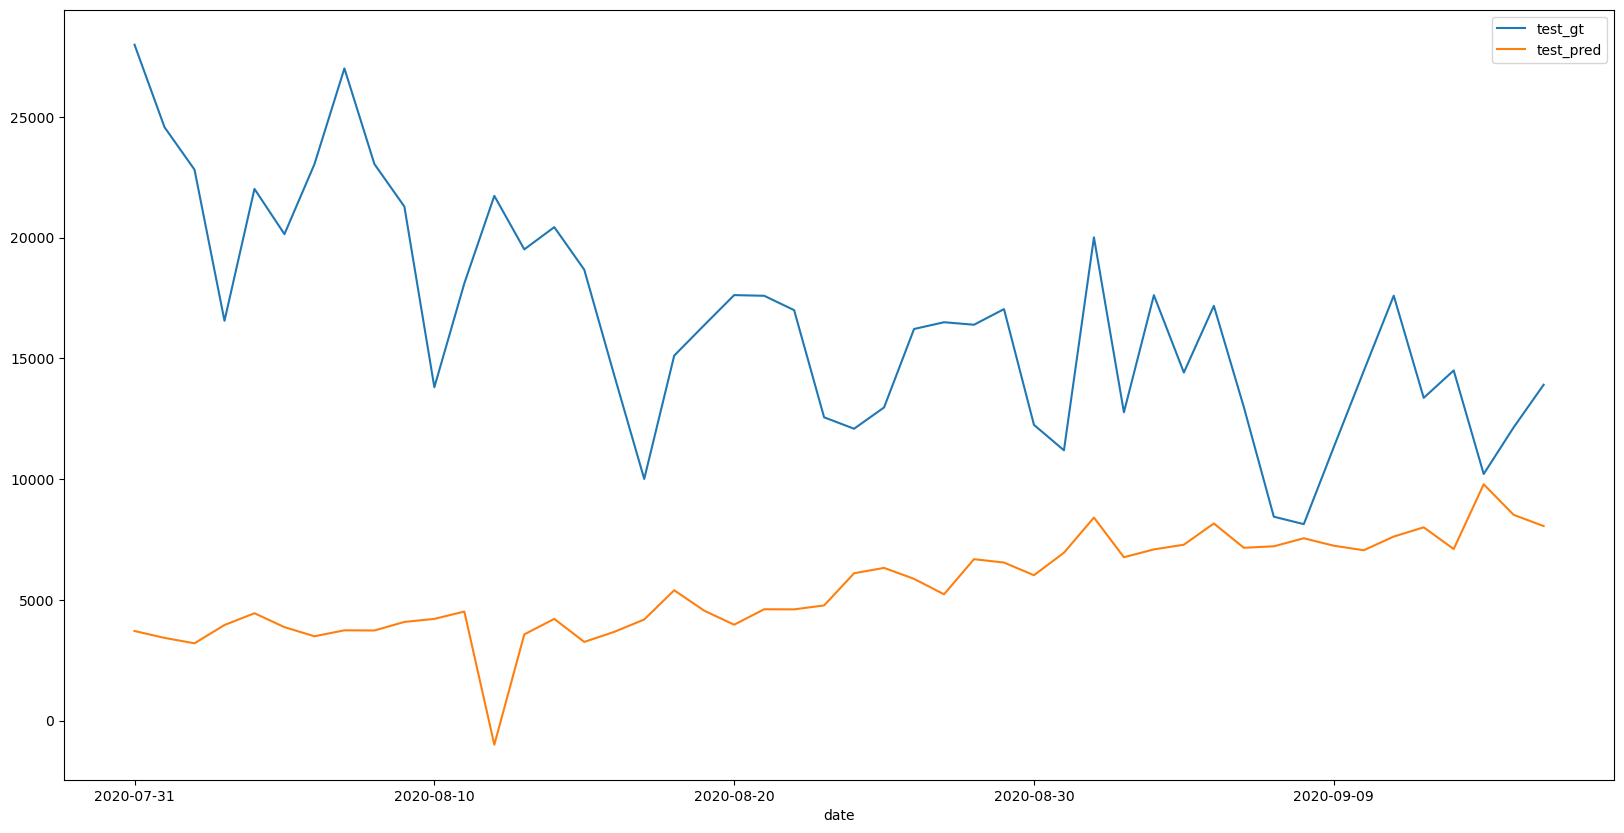

In [273]:
# Visualizing test data fitted values
s_test_pred = s_tuned_forecast["yhat"]
s_test_pred.index = s_test_plot.index
pd.concat([s_test_plot, s_test_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['test_gt', 'test_pred'])

In [274]:
# MAE
mean_absolute_error(s_test_plot, s_test_pred)

11042.41166887129

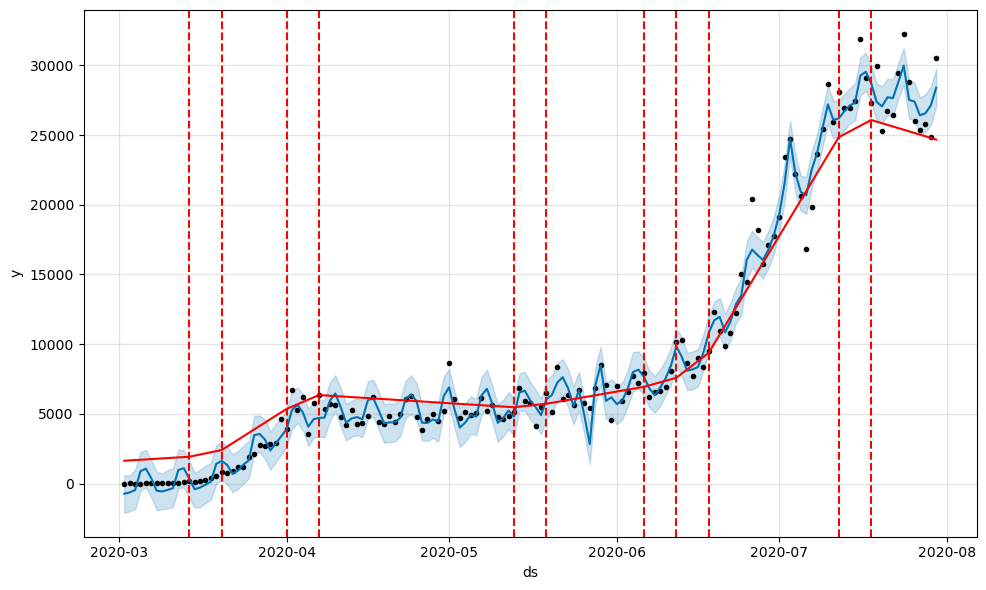

In [279]:
# Visualizing change points
fig = s_tuned_prophet.plot(s_tuned_forecast)
a = add_changepoints_to_plot(fig.gca(), s_tuned_prophet, s_tuned_forecast)

In [280]:
# Regressor Coefficients
regressor_coefficients(s_tuned_prophet)[["regressor", "coef"]].sort_values("coef")

,regressor,coef
1,num__temperature,-147.977567
0,num__daily_state_test,1520.454139
